# Supervised

## PreProcessing

In [9]:
import time
# To see all the results at the end
results = []

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score


In [10]:
from parsing import location_data

df = location_data('Dataset/location-history.json')
df.head()


,start_time,end_time,type,start_location,end_location,start_lat,start_lon,end_lat,end_lon,distance_m,transport_type,transport_prob,location,semantic_type,place_id,visit_prob,hierarchy_level,duration_min
0,2019-01-19 17:14:11.093000+00:00,2019-01-19 18:27:49.991000+00:00,visit,None,None,NaN,NaN,NaN,NaN,NaN,None,None,"29.334359,48.074422",Unknown,ChIJ3_apibudzz8Rdo43YudNz7s,0.612015,0,73.648300
1,2025-01-26 22:56:08.538000+00:00,2025-01-26 23:00:10.669000+00:00,visit,None,None,NaN,NaN,NaN,NaN,NaN,None,None,"33.997149,-117.555678",Unknown,ChIJoUIcqzrL3IARvaZh0WKumOM,0.980356,1,4.035517
2,2023-06-29 18:13:59.999000+00:00,2023-06-29 18:24:59.999000+00:00,activity,"30.084147,31.329360","30.103328,31.377261",30.084147,31.329360,30.103328,31.377261,6214.0,in passenger vehicle,0.000000,None,None,None,None,None,11.000000
3,2025-04-04 19:02:57.592000+00:00,2025-04-04 19:34:46.447000+00:00,visit,None,None,NaN,NaN,NaN,NaN,NaN,None,None,"33.978256,-117.556005",Unknown,ChIJkUd70HDK3IARRo_lhXEKKCc,0.865734,1,31.814250
4,2019-12-28 14:05:45.105000+00:00,2019-12-28 14:39:26.351000+00:00,activity,"29.267823,47.992789","29.334046,48.075174",29.267823,47.992789,29.334046,48.075174,11202.0,in passenger vehicle,0.000000,None,None,None,None,None,33.687433


In [11]:
# Filter for activity type
df = df[df["type"] == "activity"].copy()
df.head()

,start_time,end_time,type,start_location,end_location,start_lat,start_lon,end_lat,end_lon,distance_m,transport_type,transport_prob,location,semantic_type,place_id,visit_prob,hierarchy_level,duration_min
2,2023-06-29 18:13:59.999000+00:00,2023-06-29 18:24:59.999000+00:00,activity,"30.084147,31.329360","30.103328,31.377261",30.084147,31.329360,30.103328,31.377261,6214.0,in passenger vehicle,0.000000,None,None,None,None,None,11.000000
4,2019-12-28 14:05:45.105000+00:00,2019-12-28 14:39:26.351000+00:00,activity,"29.267823,47.992789","29.334046,48.075174",29.267823,47.992789,29.334046,48.075174,11202.0,in passenger vehicle,0.000000,None,None,None,None,None,33.687433
6,2024-02-12 17:50:35.999000+00:00,2024-02-12 18:27:03.018000+00:00,activity,"29.997275,31.196285","30.007844,31.146776",29.997275,31.196285,30.007844,31.146776,7820.0,in passenger vehicle,0.000000,None,None,None,None,None,36.450317
9,2020-01-02 07:56:31.787000+00:00,2020-01-02 08:13:04.365000+00:00,activity,"30.109031,31.367551","30.032363,31.259842",30.109031,31.367551,30.032363,31.259842,13420.0,in passenger vehicle,0.000000,None,None,None,None,None,16.542967
11,2023-12-06 14:29:11.913000+00:00,2023-12-06 14:54:53.425000+00:00,activity,"29.336399,48.030184","29.170550,48.116856",29.336399,48.030184,29.170550,48.116856,20429.0,in passenger vehicle,0.000000,None,None,None,None,None,25.691867


## Feature Engineering

In [12]:
# Drop NaN values
df = df.dropna(subset=["start_time", "duration_min", "distance_m", "start_lat", "start_lon"])

# Drop 'other' transport types
df["transport_type"] = df["transport_type"].replace({
    "in bus": "public transport",
    "in subway": "public transport",
    "in train": "public transport",
    "in tram": "public transport",
    "flying": "other",
    "unknown": "other"
})
df = df[df["transport_type"] != "other"]

# Drop invalid durations
df = df[df["duration_min"] > 0]

# speed in km/h
df["speed_kmph"] = (df["distance_m"] / 1000) / (df["duration_min"] / 60)
df = df[df["speed_kmph"] < 200]  # removing unrealistic speeds

# time features
df["hour"] = df["start_time"].dt.hour
df["day_of_week"] = df["start_time"].dt.day_name()
df["is_weekend"] = df["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

# Distance per minute
df["distance_per_min"] = df["distance_m"] / df["duration_min"]

# Assign country based on GPS coordinates
def get_country(lat, lon):
    if 22 <= lat <= 32 and 25 <= lon <= 35:
        return "Egypt"
    elif 28 <= lat <= 31 and 46 <= lon <= 49:
        return "Kuwait"
    elif 24 <= lat <= 49 and -125 <= lon <= -66:
        return "USA"
    else:
        return "Other"

df["country"] = df.apply(lambda row: get_country(row["start_lat"], row["start_lon"]), axis=1)


df[["start_time", "transport_type", "speed_kmph", "duration_min", "country"]].head()


,start_time,transport_type,speed_kmph,duration_min,country
2,2023-06-29 18:13:59.999000+00:00,in passenger vehicle,33.894545,11.000000,Egypt
4,2019-12-28 14:05:45.105000+00:00,in passenger vehicle,19.951654,33.687433,Kuwait
6,2024-02-12 17:50:35.999000+00:00,in passenger vehicle,12.872316,36.450317,Egypt
9,2020-01-02 07:56:31.787000+00:00,in passenger vehicle,48.673253,16.542967,Egypt
11,2023-12-06 14:29:11.913000+00:00,in passenger vehicle,47.709262,25.691867,Kuwait


## Egypt

In [13]:
egypt_df = df[df["country"] == "Egypt"].copy()

# distribution of transport types
egypt_df["transport_type"].value_counts()


transport_type
in passenger vehicle    858
walking                 109
public transport         11
Name: count, dtype: int64

In [14]:
features = ["speed_kmph", "hour", "duration_min", "distance_m", "distance_per_min"]
X = egypt_df[features]
y = egypt_df["transport_type"]


### Random Forest

                      precision    recall  f1-score   support

in passenger vehicle       0.94      0.97      0.95       172
    public transport       0.00      0.00      0.00         2
             walking       0.72      0.59      0.65        22

            accuracy                           0.91       196
           macro avg       0.55      0.52      0.53       196
        weighted avg       0.90      0.91      0.91       196



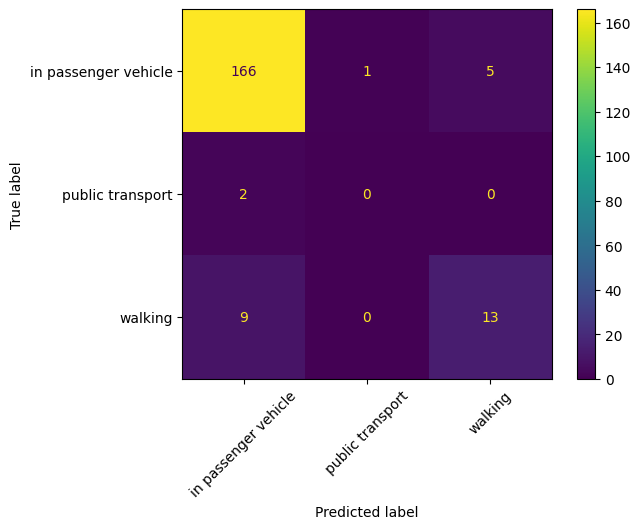

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Start timer
start_time = time.time()

# Train model
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# End timer
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)  # time in seconds

# Evaluate
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

# results
results.append({
    "Country": "Egypt",
    "Model": "Random Forest",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})

# confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, xticks_rotation=45)


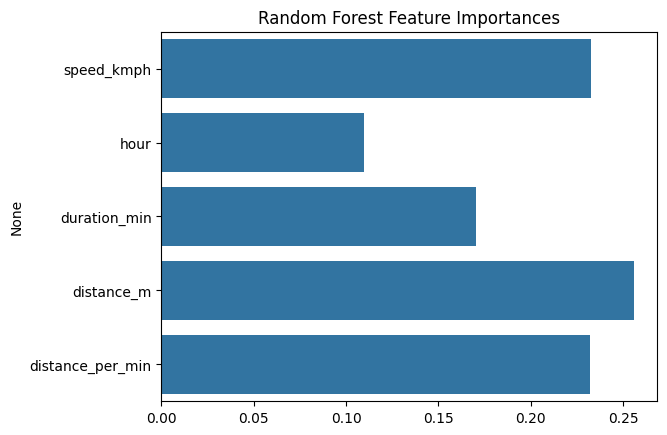

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("Random Forest Feature Importances")
plt.show()


#### Hyperparameter Tuning

##### GridSearch CV

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
                      precision    recall  f1-score   support

in passenger vehicle       0.95      0.94      0.94       172
    public transport       0.00      0.00      0.00         2
             walking       0.60      0.68      0.64        22

            accuracy                           0.90       196
           macro avg       0.52      0.54      0.53       196
        weighted avg       0.90      0.90      0.90       196



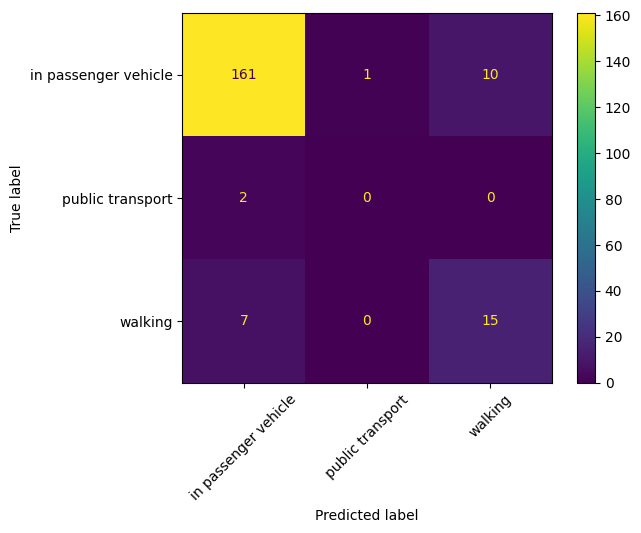

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

# Start timer
start_time = time.time()

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

# GridSearchCV
grid = GridSearchCV( RandomForestClassifier(random_state=42, class_weight="balanced"), param_grid=param_grid, scoring="f1_weighted", cv=5, n_jobs=-1, verbose=1)

# Fit the model
grid.fit(X_train, y_train)

# End timer
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)

# Best model and evaluation
best_rf = grid.best_estimator_
print("Best Params:", grid.best_params_)

# Predict and evaluate
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

results.append({
    "Country": "Egypt",
    "Model": "Random Forest GridSearch CV",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, xticks_rotation=45)


### XGBoost

                      precision    recall  f1-score   support

in passenger vehicle       0.93      0.95      0.94       172
    public transport       0.00      0.00      0.00         2
             walking       0.63      0.55      0.59        22

            accuracy                           0.90       196
           macro avg       0.52      0.50      0.51       196
        weighted avg       0.89      0.90      0.89       196



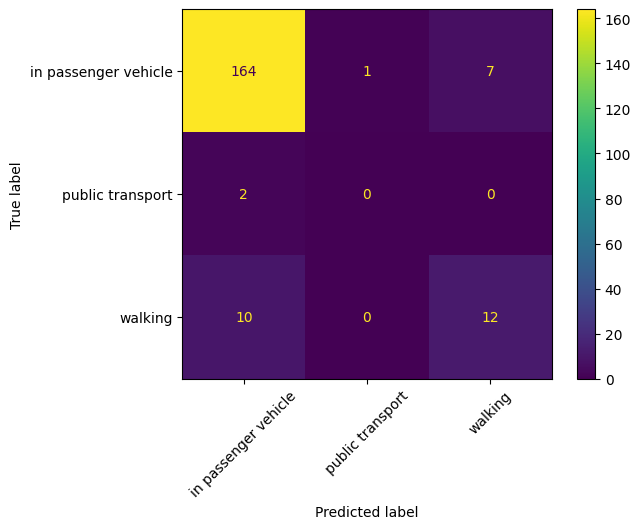

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score


features = ["speed_kmph", "hour", "duration_min", "distance_m", "distance_per_min"]
X = egypt_df[features]
y = egypt_df["transport_type"]

# labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

start_time = time.time()
xgb_model = XGBClassifier(random_state=42, eval_metric="mlogloss")
xgb_model.fit(X_train, y_train)
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)


y_pred = xgb_model.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)


print(classification_report(y_test_labels, y_pred_labels))

accuracy = accuracy_score(y_test_labels, y_pred_labels)
macro_f1 = f1_score(y_test_labels, y_pred_labels, average='macro')
macro_precision = precision_score(y_test_labels, y_pred_labels, average='macro')
macro_recall = recall_score(y_test_labels, y_pred_labels, average='macro')

results.append({
    "Country": "Egypt",
    "Model": "XGBoost",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})

ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, xticks_rotation=45)


#### GridSearchCV

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
                      precision    recall  f1-score   support

in passenger vehicle       0.94      0.95      0.94       172
    public transport       0.00      0.00      0.00         2
             walking       0.64      0.64      0.64        22

            accuracy                           0.90       196
           macro avg       0.53      0.53      0.53       196
        weighted avg       0.90      0.90      0.90       196



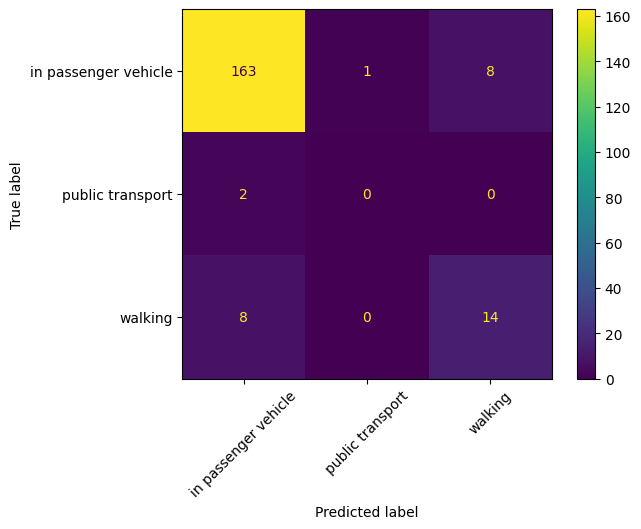

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score


# labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}


grid = GridSearchCV(XGBClassifier(random_state=42, eval_metric='mlogloss'), param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1)

# Start timer
start_time = time.time()
grid.fit(X_train, y_train)
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)

# Best model
best_xgb = grid.best_estimator_
print("Best Params:", grid.best_params_)

# Predict + decode
y_pred = best_xgb.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Report
print(classification_report(y_test_labels, y_pred_labels))
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, xticks_rotation=45)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
macro_f1 = f1_score(y_test_labels, y_pred_labels, average='macro')
macro_precision = precision_score(y_test_labels, y_pred_labels, average='macro')
macro_recall = recall_score(y_test_labels, y_pred_labels, average='macro')
macro_f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

results.append({
    "Country": "Egypt",
    "Model": "XGBoost (Tuned)",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


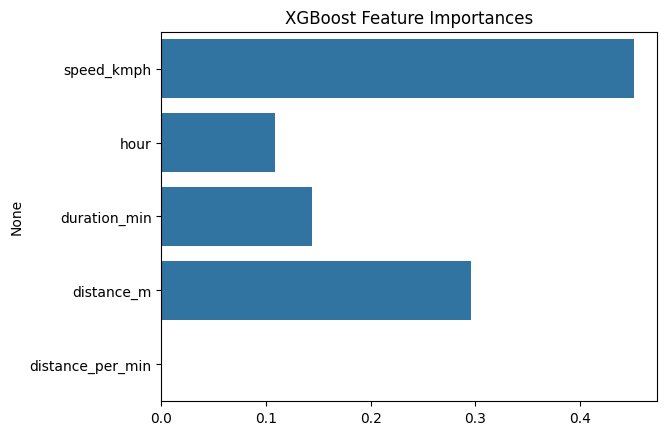

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = best_xgb.feature_importances_
sns.barplot(x=importances, y=X.columns)
plt.title("XGBoost Feature Importances")
plt.show()


### Decision Tree

Decision Tree Classification Report:
                      precision    recall  f1-score   support

in passenger vehicle       0.96      0.77      0.85       172
    public transport       0.00      0.00      0.00         2
             walking       0.50      0.77      0.61        22

            accuracy                           0.76       196
           macro avg       0.49      0.51      0.49       196
        weighted avg       0.90      0.76      0.82       196



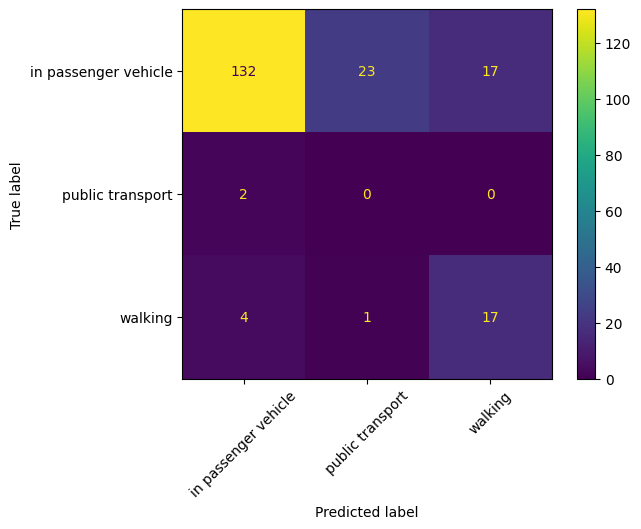

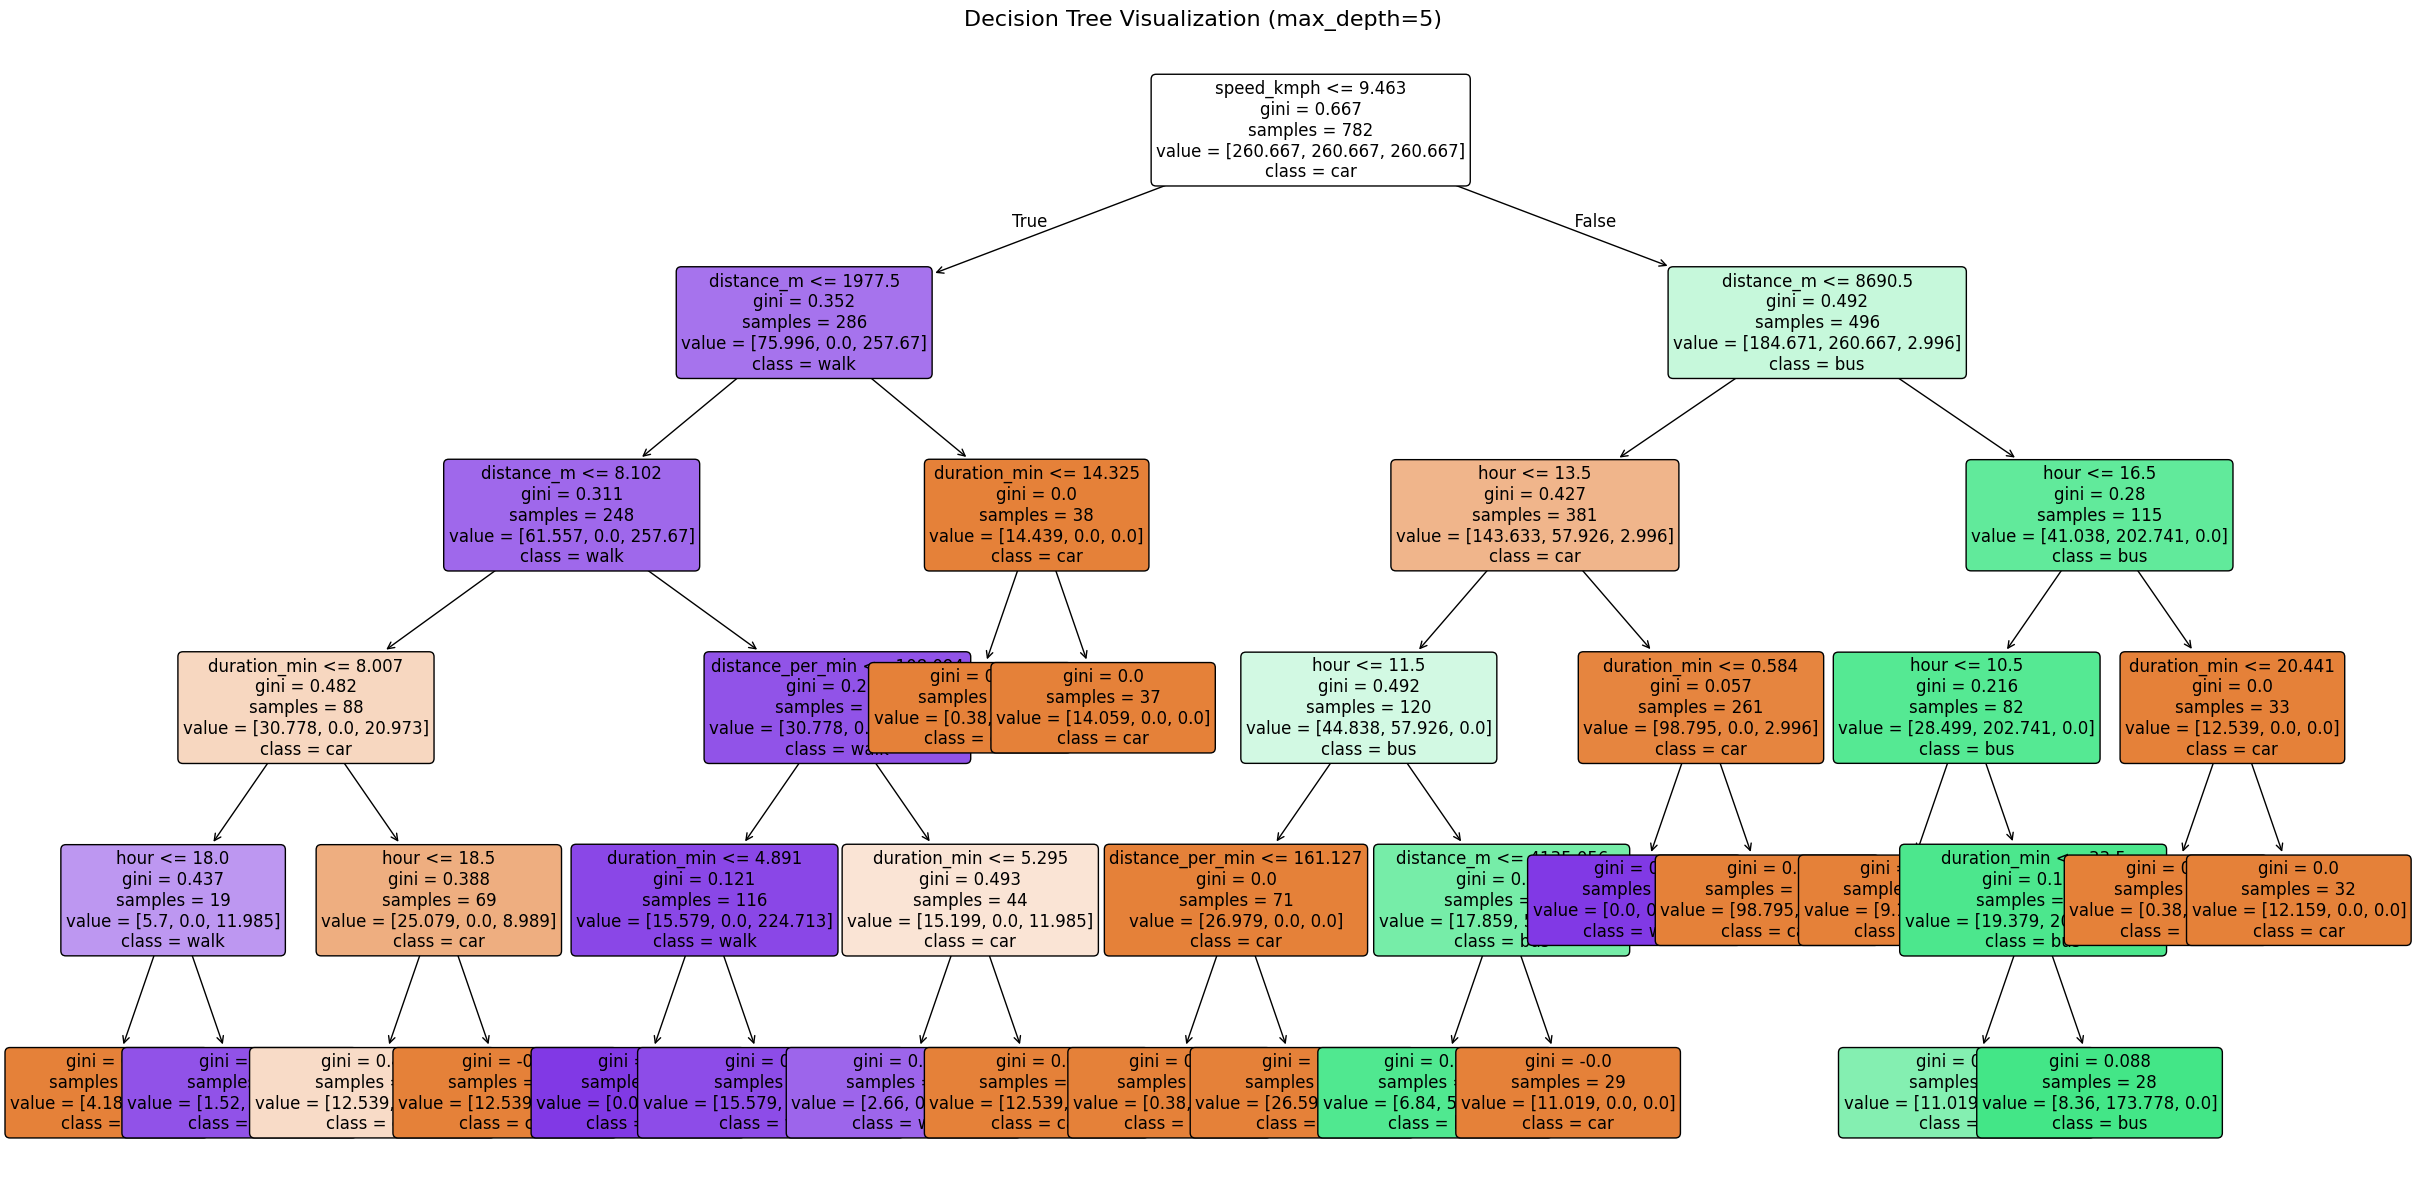

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42)

# Train Decision Tree
dt_model = DecisionTreeClassifier( max_depth=5, class_weight="balanced", random_state=42)

# Start timer
start_time = time.time()
dt_model.fit(X_train, y_train)
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)

# Predict and decode
y_pred = dt_model.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Evaluate
print("Decision Tree Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, xticks_rotation=45)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
macro_f1 = f1_score(y_test_labels, y_pred_labels, average='macro')
macro_precision = precision_score(y_test_labels, y_pred_labels, average='macro')
macro_recall = recall_score(y_test_labels, y_pred_labels, average='macro')
macro_f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

results.append({
    "Country": "Egypt",
    "Model": "Decision Tree",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})

# Decision tree visualization
short_labels = {
    "in passenger vehicle": "car",
    "public transport": "bus",
    "walking": "walk"
}
class_labels = [short_labels[label] for label in le.classes_]

plt.figure(figsize=(30, 15))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=class_labels,
    filled=True,
    rounded=True,
    proportion=False,
    fontsize=12
)
plt.title("Decision Tree Visualization (max_depth=5)", fontsize=16)
plt.show()


## Kuwait

In [22]:
kuwait_df = df[df["country"] == "Kuwait"].copy()

# transport types
kuwait_df["transport_type"].value_counts()



transport_type
in passenger vehicle    1519
walking                   53
cycling                    6
Name: count, dtype: int64

In [23]:
features = ["speed_kmph", "hour", "duration_min", "distance_m", "distance_per_min"]
X_kuwait = kuwait_df[features]
y_kuwait = kuwait_df["transport_type"]

### Random Forest

Random Forest (Kuwait):
                      precision    recall  f1-score   support

             cycling       0.00      0.00      0.00         1
in passenger vehicle       0.97      0.99      0.98       304
             walking       0.40      0.18      0.25        11

            accuracy                           0.96       316
           macro avg       0.46      0.39      0.41       316
        weighted avg       0.95      0.96      0.95       316



/home/phillip/Machine-Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/phillip/Machine-Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/phillip/Machine-Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

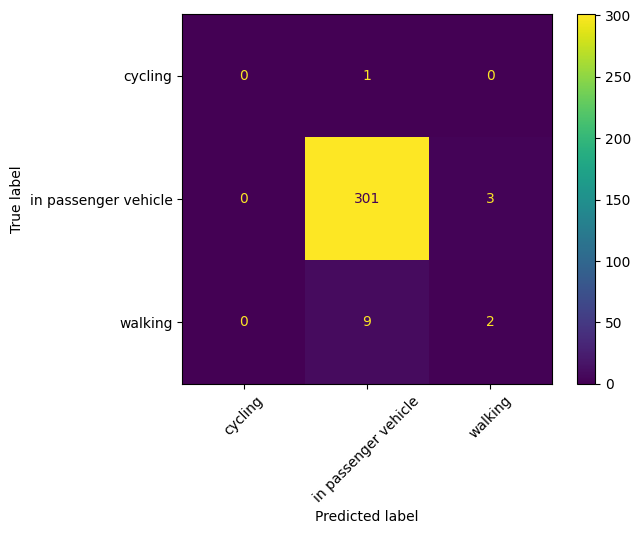

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# labels
le_kuwait = LabelEncoder()
y_kuwait_enc = le_kuwait.fit_transform(y_kuwait)

# train/test split
Xk_train, Xk_test, yk_train, yk_test = train_test_split(X_kuwait, y_kuwait_enc, test_size=0.2, random_state=42, stratify=y_kuwait_enc)

# Train Random Forest with timing
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
start_time = time.time()
rf_model.fit(Xk_train, yk_train)
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)

# Predict
yk_pred = rf_model.predict(Xk_test)

# Decoding predictions
yk_test_labels = le_kuwait.inverse_transform(yk_test)
yk_pred_labels = le_kuwait.inverse_transform(yk_pred)

# Evaluate
print("Random Forest (Kuwait):")
print(classification_report(yk_test_labels, yk_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, yk_pred_labels, xticks_rotation=45)

accuracy = accuracy_score(yk_test_labels, yk_pred_labels)
macro_f1 = f1_score(yk_test_labels, yk_pred_labels, average='macro')

# Store results
results.append({
    "Country": "Kuwait",
    "Model": "Random Forest",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


#### Hyperparameter Tuning

##### GridSearchCV

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Random Forest (Kuwait):
                      precision    recall  f1-score   support

             cycling       0.00      0.00      0.00         1
in passenger vehicle       0.97      0.98      0.98       304
             walking       0.38      0.27      0.32        11

            accuracy                           0.96       316
           macro avg       0.45      0.42      0.43       316
        weighted avg       0.95      0.96      0.95       316



/home/phillip/Machine-Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/phillip/Machine-Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/phillip/Machine-Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

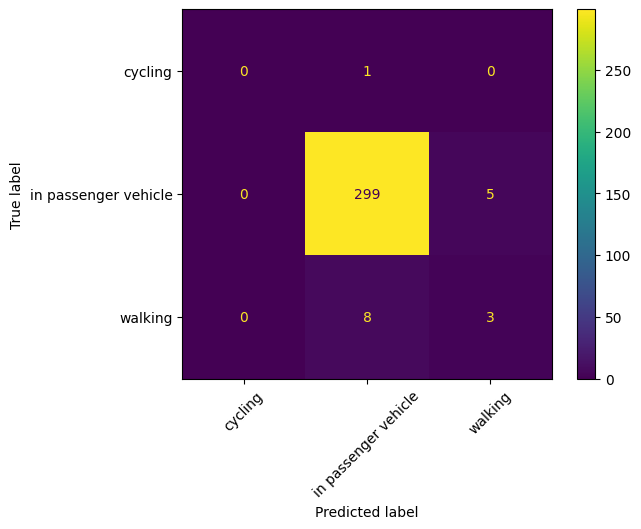

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score


param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

# GridSearchCV with class weights
grid_kuwait = GridSearchCV( RandomForestClassifier(random_state=42, class_weight="balanced"), param_grid=param_grid, scoring="f1_weighted",cv=5, n_jobs=-1, verbose=1)

# Fit grid search with timing
start_time = time.time()
grid_kuwait.fit(Xk_train, yk_train)
end_time = time.time()
elapsed_time = round(end_time - start_time, 2)

# Best estimator
best_rf_kuwait = grid_kuwait.best_estimator_
print("Best Params:", grid_kuwait.best_params_)

# Predict
yk_pred_best = best_rf_kuwait.predict(Xk_test)

# Decode
yk_pred_labels_best = le_kuwait.inverse_transform(yk_pred_best)
yk_test_labels = le_kuwait.inverse_transform(yk_test)

# Evaluate
print("Tuned Random Forest (Kuwait):")
print(classification_report(yk_test_labels, yk_pred_labels_best))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, yk_pred_labels_best, xticks_rotation=45)

# results
accuracy = accuracy_score(yk_test_labels, yk_pred_labels_best)
macro_f1 = f1_score(yk_test_labels, yk_pred_labels_best, average='macro')

results.append({
    "Country": "Kuwait",
    "Model": "Random Forest (Tuned)",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


##### Oversampling

In [26]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# oversampling
ros = RandomOverSampler(random_state=42)
Xk_train_resampled, yk_train_resampled = ros.fit_resample(Xk_train, yk_train)

# Class distribution after oversampling
print("Resampled class distribution (Kuwait):")
print(Counter(le_kuwait.inverse_transform(yk_train_resampled)))

Resampled class distribution (Kuwait):
Counter({'in passenger vehicle': 1215, 'walking': 1215, 'cycling': 1215})


Random Forest with Oversampling (Kuwait):
                      precision    recall  f1-score   support

             cycling       0.00      0.00      0.00         1
in passenger vehicle       0.97      0.98      0.97       304
             walking       0.33      0.27      0.30        11

            accuracy                           0.95       316
           macro avg       0.43      0.42      0.42       316
        weighted avg       0.95      0.95      0.95       316



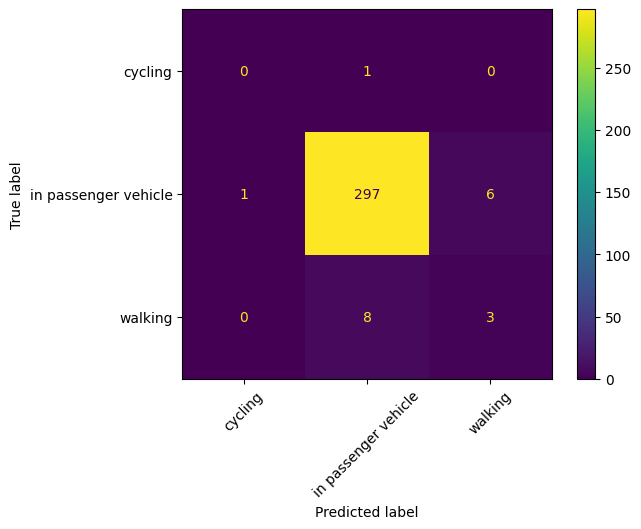

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

# Start timer
start_time = time.time()

# Train model on resampled data
rf_os_model = RandomForestClassifier(random_state=42)
rf_os_model.fit(Xk_train_resampled, yk_train_resampled)

# Timing End
elapsed_time = round(time.time() - start_time, 2)

# Predict and evaluate
yk_os_pred = rf_os_model.predict(Xk_test)
yk_os_pred_labels = le_kuwait.inverse_transform(yk_os_pred)
yk_test_labels = le_kuwait.inverse_transform(yk_test)

print("Random Forest with Oversampling (Kuwait):")
print(classification_report(yk_test_labels, yk_os_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, yk_os_pred_labels, xticks_rotation=45)

# results
accuracy = accuracy_score(yk_test_labels, yk_os_pred_labels)
macro_f1 = f1_score(yk_test_labels, yk_os_pred_labels, average='macro')

results.append({
    "Country": "Kuwait",
    "Model": "Random Forest (Oversampled)",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


### XGBoost

Resampled class distribution (Kuwait):
Counter({'in passenger vehicle': 1215, 'walking': 1215, 'cycling': 1215})
XGBoost with Oversampling (Kuwait):
                      precision    recall  f1-score   support

             cycling       0.00      0.00      0.00         1
in passenger vehicle       0.97      0.97      0.97       304
             walking       0.36      0.36      0.36        11

            accuracy                           0.95       316
           macro avg       0.45      0.45      0.45       316
        weighted avg       0.95      0.95      0.95       316



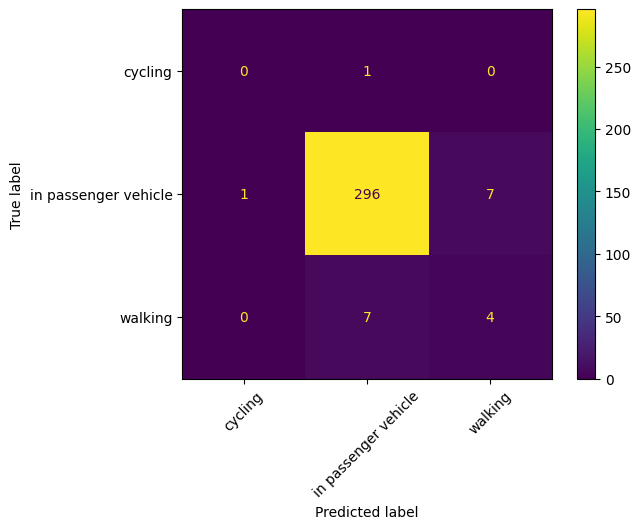

In [ ]:

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Encode target labels
le_kuwait = LabelEncoder()
y_kuwait_enc = le_kuwait.fit_transform(y_kuwait)

# Train test split
Xk_train, Xk_test, yk_train, yk_test = train_test_split(
    X_kuwait, y_kuwait_enc, test_size=0.2, random_state=42, stratify=y_kuwait_enc
)

# oversampling
ros = RandomOverSampler(random_state=42)
Xk_res, yk_res = ros.fit_resample(Xk_train, yk_train)

print("Resampled class distribution (Kuwait):")
print(Counter(le_kuwait.inverse_transform(yk_res)))

# start timer
start_time = time.time()

# Train XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric="mlogloss")
xgb_model.fit(Xk_res, yk_res)

# Timing End
elapsed_time = round(time.time() - start_time, 2)

# Predict
y_pred = xgb_model.predict(Xk_test)

# Decode
yk_test_labels = le_kuwait.inverse_transform(yk_test)
y_pred_labels = le_kuwait.inverse_transform(y_pred)

# Report
print("XGBoost with Oversampling (Kuwait):")
print(classification_report(yk_test_labels, y_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, y_pred_labels, xticks_rotation=45)

# results
accuracy = accuracy_score(yk_test_labels, y_pred_labels)
macro_f1 = f1_score(yk_test_labels, y_pred_labels, average='macro')

results.append({
    "Country": "Kuwait",
    "Model": "XGBoost (Oversampled)",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


#### Hyperparameter Tuning

##### GridSearchCV

In [29]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Oversampling the training data
ros = RandomOverSampler(random_state=42)
Xk_resampled, yk_resampled = ros.fit_resample(Xk_train, yk_train)

print("Resampled class distribution (Kuwait):")
print(Counter(yk_resampled))


Resampled class distribution (Kuwait):
Counter({np.int64(1): 1215, np.int64(2): 1215, np.int64(0): 1215})


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}

XGBoost (Tuned) Classification Report (Kuwait):
                      precision    recall  f1-score   support

             cycling       0.00      0.00      0.00         1
in passenger vehicle       0.97      0.98      0.98       304
             walking       0.40      0.36      0.38        11

            accuracy                           0.95       316
           macro avg       0.46      0.45      0.45       316
        weighted avg       0.95      0.95      0.95       316



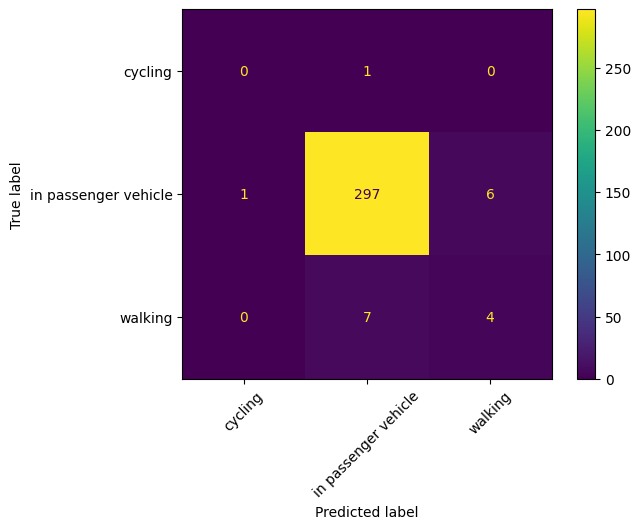

In [ ]:

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# XGB Classifier 
xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')

grid = GridSearchCV( estimator=xgb, param_grid=param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1)

# Start timing
start_time = time.time()

# Fit model
grid.fit(Xk_resampled, yk_resampled)

elapsed_time = round(time.time() - start_time, 2)

# Best estimator
best_xgb = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predict
y_pred = best_xgb.predict(Xk_test)

# Decode
yk_test_labels = le_kuwait.inverse_transform(yk_test)
y_pred_labels = le_kuwait.inverse_transform(y_pred)

# Evaluate
print("\nXGBoost (Tuned) Classification Report (Kuwait):")
print(classification_report(yk_test_labels, y_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, y_pred_labels, xticks_rotation=45)

# results
accuracy = accuracy_score(yk_test_labels, y_pred_labels)
macro_f1 = f1_score(yk_test_labels, y_pred_labels, average='macro')

results.append({
    "Country": "Kuwait",
    "Model": "XGBoost (Tuned, Resampled)",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


### GridSearchCV Tuned

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params (Kuwait): {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0}
XGBoost (Tuned) Classification Report (Kuwait):
                      precision    recall  f1-score   support

             cycling       0.00      0.00      0.00         1
in passenger vehicle       0.97      0.99      0.98       304
             walking       0.57      0.36      0.44        11

            accuracy                           0.97       316
           macro avg       0.52      0.45      0.48       316
        weighted avg       0.96      0.97      0.96       316



/home/phillip/Machine-Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/phillip/Machine-Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/phillip/Machine-Learning/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

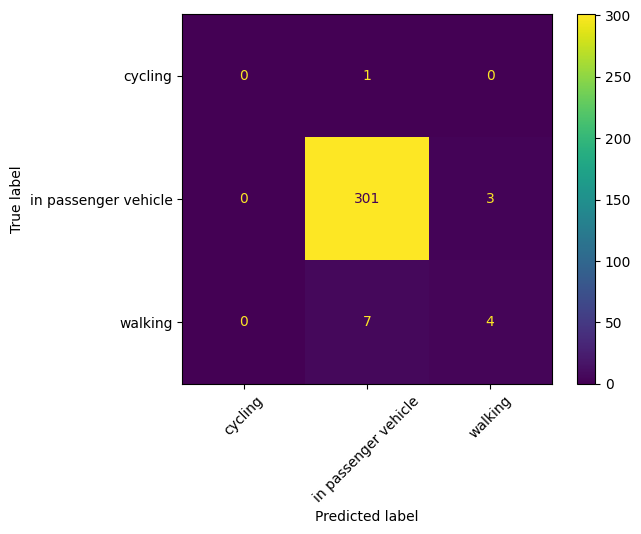

In [ ]:

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

# labels
le_kuwait = LabelEncoder()
yk_encoded = le_kuwait.fit_transform(y_kuwait)

# Split Kuwait data
Xk_train, Xk_test, yk_train, yk_test = train_test_split( X_kuwait, yk_encoded, stratify=yk_encoded, test_size=0.2, random_state=42)


param_grid_kuwait = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# GridSearchCV
grid_kuwait = GridSearchCV( XGBClassifier(random_state=42, eval_metric='mlogloss'), param_grid_kuwait, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=1)

# training time
start_time = time.time()
grid_kuwait.fit(Xk_train, yk_train)
elapsed_time = round(time.time() - start_time, 2)

# Best model
best_xgb_kuwait = grid_kuwait.best_estimator_
print("Best Params (Kuwait):", grid_kuwait.best_params_)

# Predict + decode
yk_pred = best_xgb_kuwait.predict(Xk_test)
yk_test_labels = le_kuwait.inverse_transform(yk_test)
yk_pred_labels = le_kuwait.inverse_transform(yk_pred)

# Report
print("XGBoost (Tuned) Classification Report (Kuwait):")
print(classification_report(yk_test_labels, yk_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, yk_pred_labels, xticks_rotation=45)

# results
accuracy = accuracy_score(yk_test_labels, yk_pred_labels)
macro_f1 = f1_score(yk_test_labels, yk_pred_labels, average='macro')

results.append({
    "Country": "Kuwait",
    "Model": "XGBoost (Tuned)",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


### Decision Tree

Decision Tree Classification Report (Kuwait):
                      precision    recall  f1-score   support

             cycling       0.00      0.00      0.00         1
in passenger vehicle       0.96      0.98      0.97       304
             walking       0.25      0.09      0.13        11

            accuracy                           0.95       316
           macro avg       0.40      0.36      0.37       316
        weighted avg       0.94      0.95      0.94       316



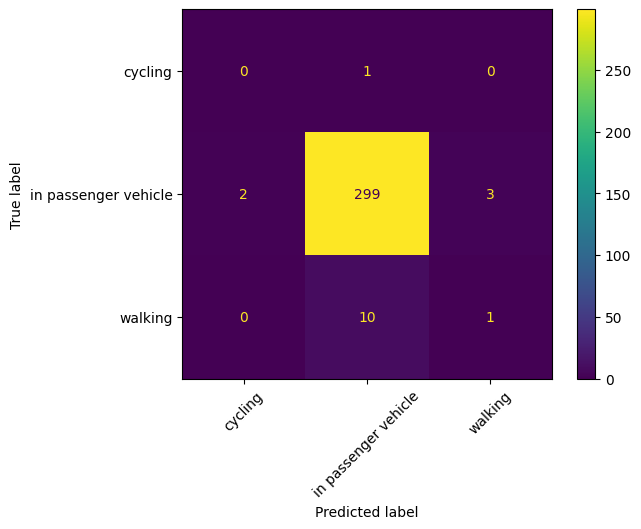

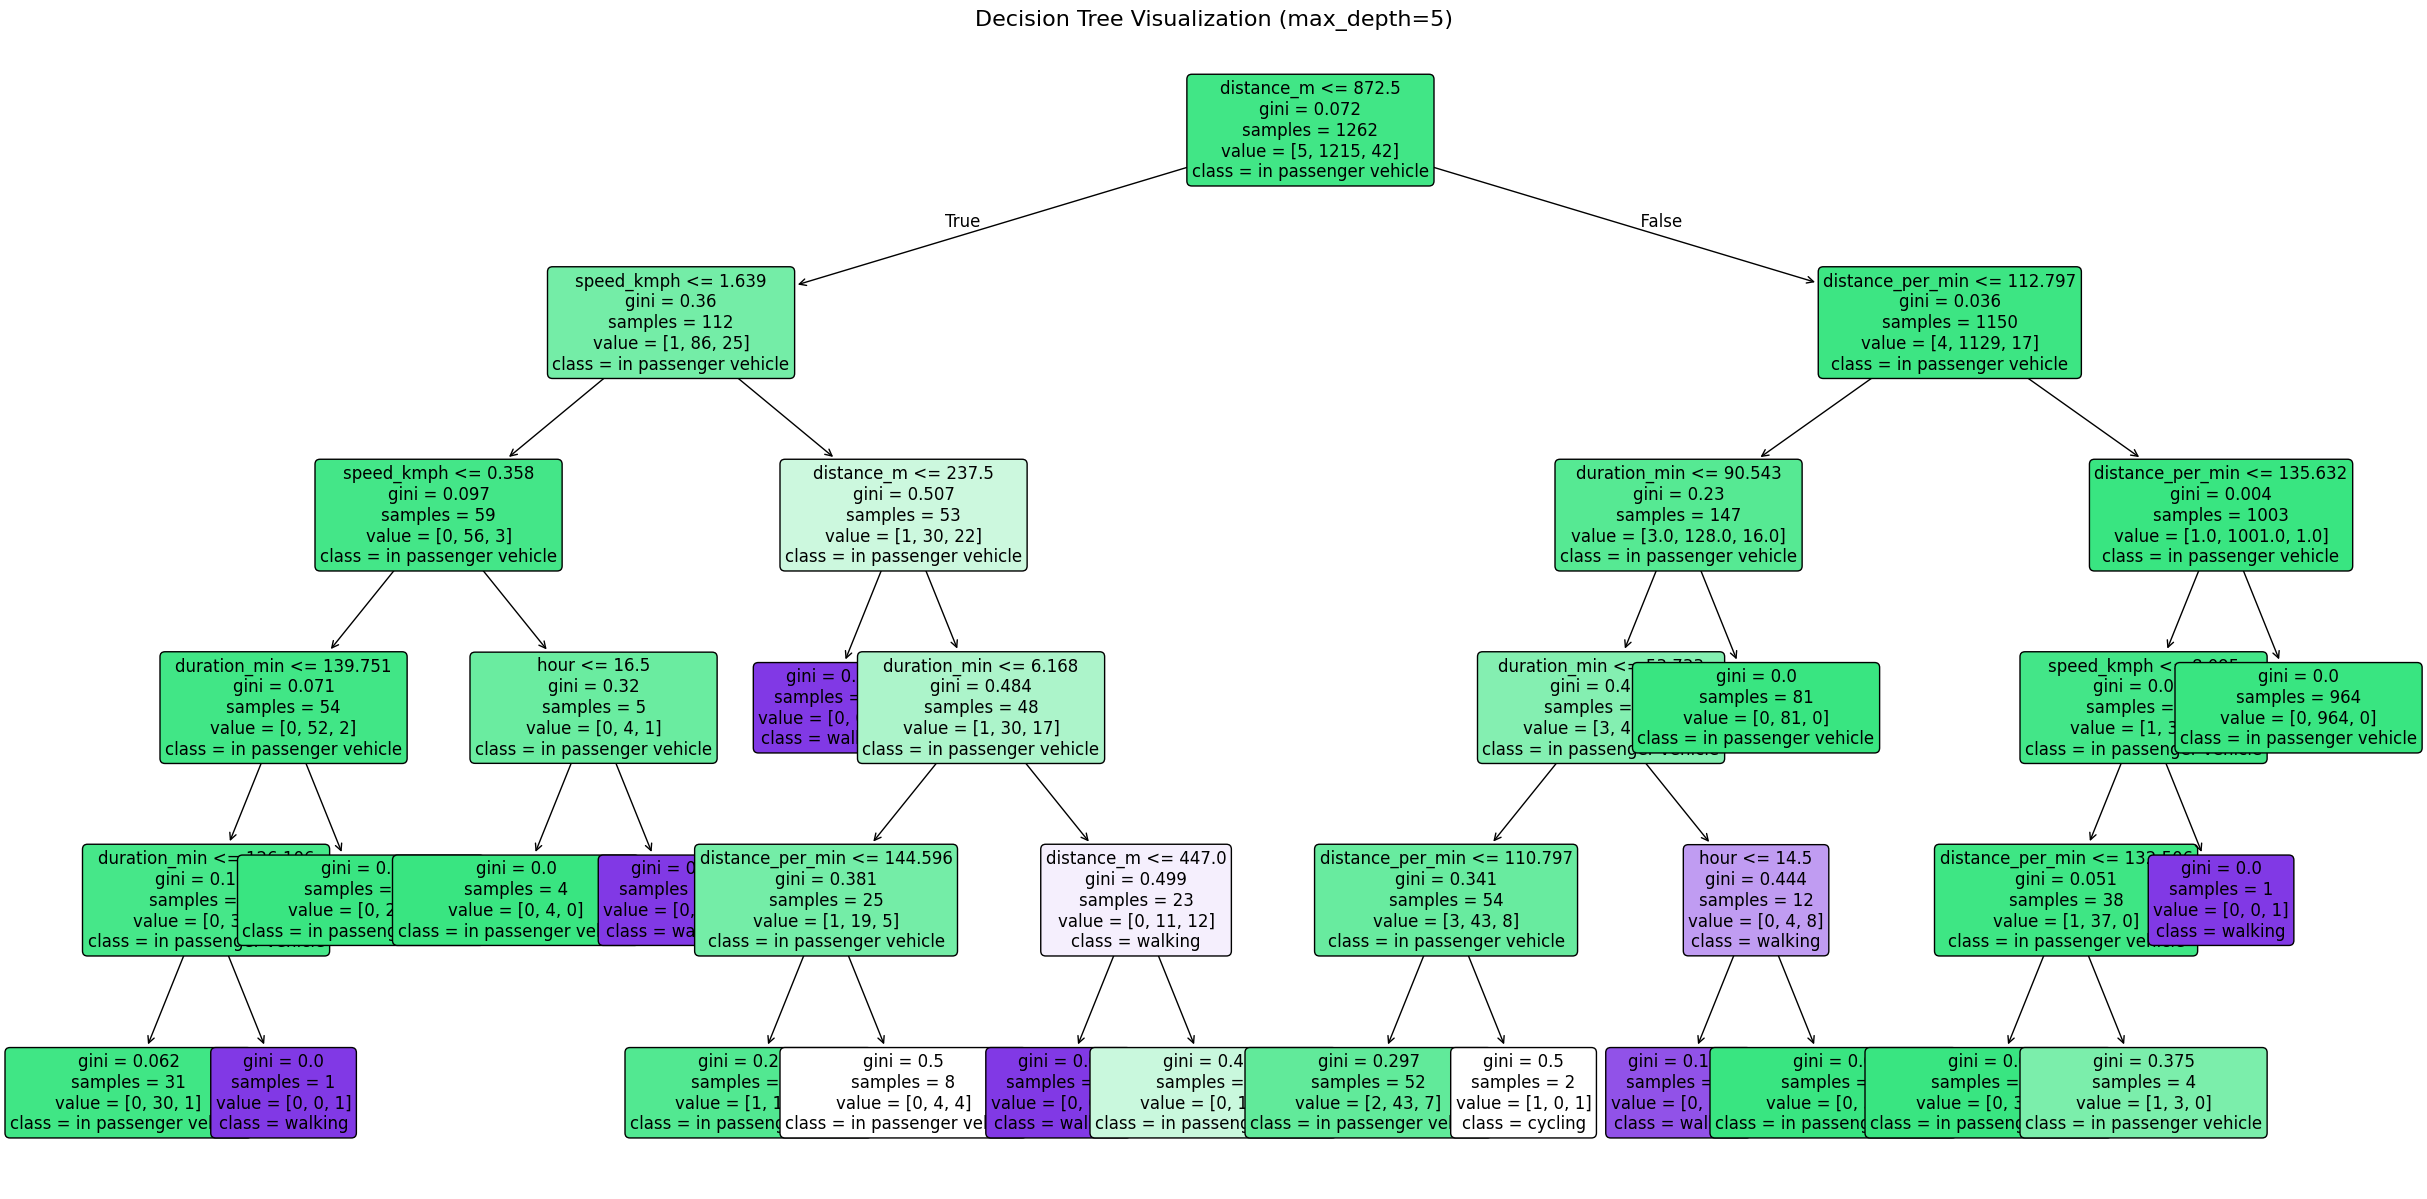

In [ ]:

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# labels
le_kuwait = LabelEncoder()
yk_encoded = le_kuwait.fit_transform(y_kuwait)

# Train-test split
Xk_train, Xk_test, yk_train, yk_test = train_test_split(X_kuwait, yk_encoded, stratify=yk_encoded, test_size=0.2, random_state=42)

# start timer
start_time = time.time()

# Train Decision Tree
dt_model_kuwait = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model_kuwait.fit(Xk_train, yk_train)

# Timing end
elapsed_time = round(time.time() - start_time, 2)

# Predict and evaluate
yk_pred = dt_model_kuwait.predict(Xk_test)
yk_test_labels = le_kuwait.inverse_transform(yk_test)
yk_pred_labels = le_kuwait.inverse_transform(yk_pred)

print("Decision Tree Classification Report (Kuwait):")
print(classification_report(yk_test_labels, yk_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, yk_pred_labels, xticks_rotation=45)

# results
accuracy = accuracy_score(yk_test_labels, yk_pred_labels)
macro_f1 = f1_score(yk_test_labels, yk_pred_labels, average='macro')

results.append({
    "Country": "Kuwait",
    "Model": "Decision Tree",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})

# Visualize tree
plt.figure(figsize=(30, 15))
plot_tree(
    dt_model_kuwait,
    feature_names=X.columns,
    class_names=le_kuwait.classes_,
    filled=True,
    rounded=True,
    proportion=False,
    fontsize=12
)
plt.title("Decision Tree Visualization (max_depth=5)", fontsize=16)
plt.show()


## USA

In [33]:
# USA
usa_df = df[df["country"] == "USA"].copy()

# distribution of transport types
usa_df["transport_type"].value_counts()



transport_type
in passenger vehicle    488
walking                  78
cycling                  77
public transport         44
Name: count, dtype: int64

In [34]:
features = ["speed_kmph", "hour", "duration_min", "distance_m", "distance_per_min"]
X_usa = usa_df[features]
y_usa = usa_df["transport_type"]

### Random Forest

Random Forest (USA):
                      precision    recall  f1-score   support

             cycling       0.77      0.67      0.71        15
in passenger vehicle       0.86      0.97      0.91        98
    public transport       0.83      0.56      0.67         9
             walking       0.62      0.31      0.42        16

            accuracy                           0.83       138
           macro avg       0.77      0.63      0.68       138
        weighted avg       0.82      0.83      0.82       138



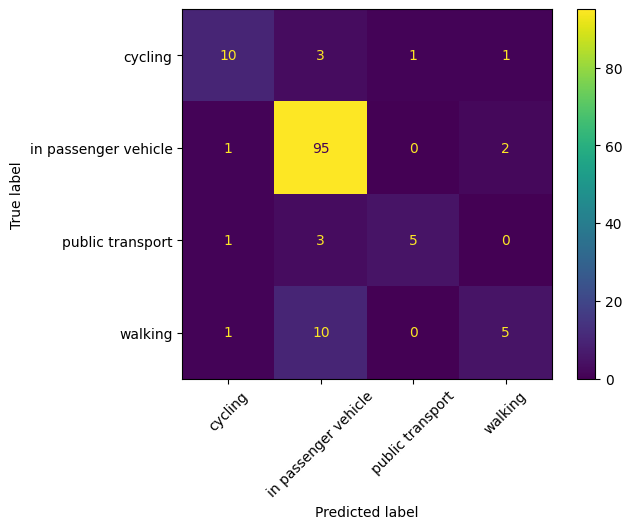

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# labels
le_usa = LabelEncoder()
y_usa_enc = le_usa.fit_transform(y_usa)

# Train/test split
Xk_train, Xk_test, yk_train, yk_test = train_test_split(
    X_usa, y_usa_enc, test_size=0.2, random_state=42, stratify=y_usa_enc
)

# start timer 
start_time = time.time()

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_model.fit(Xk_train, yk_train)

#  Timing end 
elapsed_time = round(time.time() - start_time, 2)

# Predict
yk_pred = rf_model.predict(Xk_test)

# Decode predictions
yk_test_labels = le_usa.inverse_transform(yk_test)
yk_pred_labels = le_usa.inverse_transform(yk_pred)

# Evaluate
print("Random Forest (USA):")
print(classification_report(yk_test_labels, yk_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, yk_pred_labels, xticks_rotation=45)

# results
accuracy = accuracy_score(yk_test_labels, yk_pred_labels)
macro_f1 = f1_score(yk_test_labels, yk_pred_labels, average='macro')

results.append({
    "Country": "USA",
    "Model": "Random Forest",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


#### GridSearchCV RandomForest Tuned

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest (Tuned) - USA:
                      precision    recall  f1-score   support

             cycling       0.73      0.73      0.73        15
in passenger vehicle       0.88      0.96      0.92        98
    public transport       0.86      0.67      0.75         9
             walking       0.56      0.31      0.40        16

            accuracy                           0.84       138
           macro avg       0.76      0.67      0.70       138
        weighted avg       0.82      0.84      0.83       138



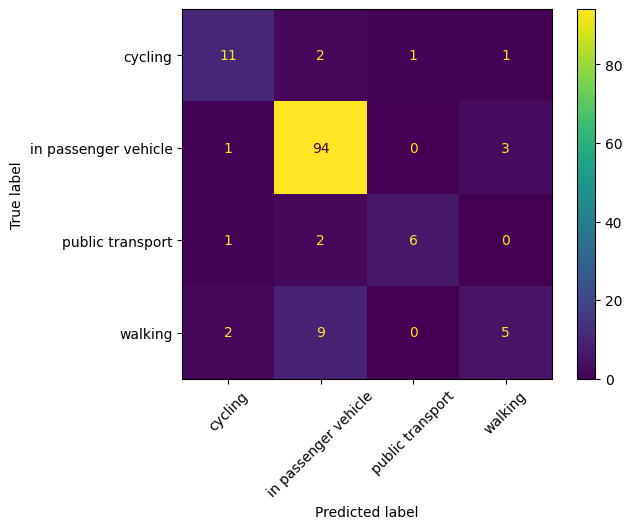

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

# labels
le_usa = LabelEncoder()
y_usa_encoded = le_usa.fit_transform(y_usa)

# Train-test split
Xu_train, Xu_test, yu_train, yu_test = train_test_split(
    X_usa, y_usa_encoded, stratify=y_usa_encoded, test_size=0.2, random_state=42
)


param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

# GridSearchCV
grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
    verbose=1
)

#  Timing the training 
start_time = time.time()
grid.fit(Xu_train, yu_train)
elapsed_time = round(time.time() - start_time, 2)

# Best estimator
best_rf_usa = grid.best_estimator_

# Evaluation
yu_pred = best_rf_usa.predict(Xu_test)
yu_test_labels = le_usa.inverse_transform(yu_test)
yu_pred_labels = le_usa.inverse_transform(yu_pred)

print("Best Parameters:", grid.best_params_)
print("\nRandom Forest (Tuned) - USA:")
print(classification_report(yu_test_labels, yu_pred_labels))
ConfusionMatrixDisplay.from_predictions(yu_test_labels, yu_pred_labels, xticks_rotation=45)

# results
accuracy = accuracy_score(yu_test_labels, yu_pred_labels)
macro_f1 = f1_score(yu_test_labels, yu_pred_labels, average='macro')

results.append({
    "Country": "USA",
    "Model": "Random Forest (Tuned)",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


### XGBoost

XGBoost Classification Report (USA):
                      precision    recall  f1-score   support

             cycling       0.71      0.67      0.69        15
in passenger vehicle       0.87      0.96      0.91        98
    public transport       0.86      0.67      0.75         9
             walking       0.67      0.38      0.48        16

            accuracy                           0.84       138
           macro avg       0.78      0.67      0.71       138
        weighted avg       0.83      0.84      0.83       138



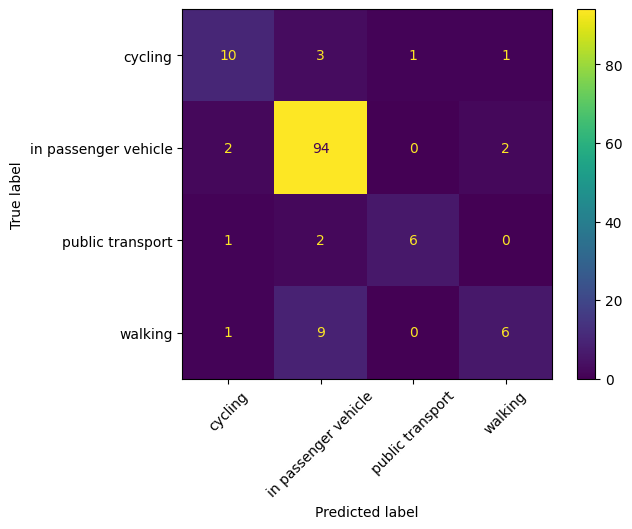

In [ ]:

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

#  Untuned XGBoost Model 
xgb_usa = XGBClassifier(random_state=42, eval_metric="mlogloss")

#  Timing the training 
start_time = time.time()
xgb_usa.fit(Xk_train, yk_train)
elapsed_time = round(time.time() - start_time, 2)

#  Predict + decode 
yk_pred = xgb_usa.predict(Xk_test)
yk_test_labels = le_usa.inverse_transform(yk_test)
yk_pred_labels = le_usa.inverse_transform(yk_pred)

#  Evaluate 
print("XGBoost Classification Report (USA):")
print(classification_report(yk_test_labels, yk_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, yk_pred_labels, xticks_rotation=45)

#  Record 
accuracy = accuracy_score(yk_test_labels, yk_pred_labels)
macro_f1 = f1_score(yk_test_labels, yk_pred_labels, average='macro')

results.append({
    "Country": "USA",
    "Model": "XGBoost",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


### GridSearchCV XGBoost Tuned

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params (USA): {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
XGBoost (Tuned) Classification Report (USA):
                      precision    recall  f1-score   support

             cycling       0.69      0.73      0.71        15
in passenger vehicle       0.87      0.96      0.91        98
    public transport       0.83      0.56      0.67         9
             walking       0.62      0.31      0.42        16

            accuracy                           0.83       138
           macro avg       0.75      0.64      0.68       138
        weighted avg       0.82      0.83      0.82       138



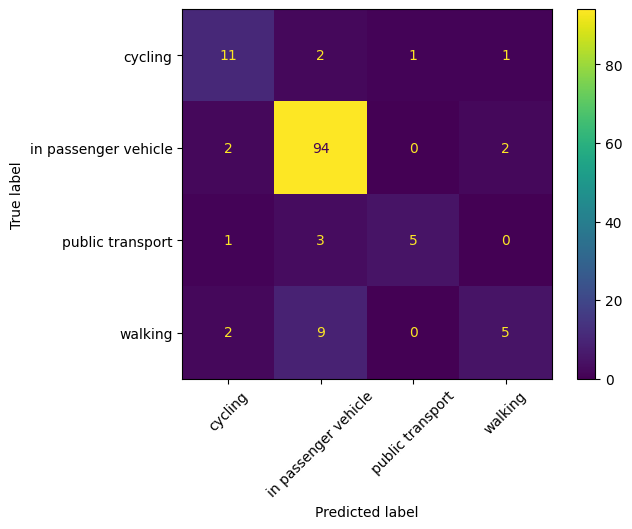

In [ ]:

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode USA labels
le_usa = LabelEncoder()
yk_encoded = le_usa.fit_transform(y_usa)

# Train/test split
Xk_train, Xk_test, yk_train, yk_test = train_test_split(
    X_usa, yk_encoded, stratify=yk_encoded, test_size=0.2, random_state=42
)


param_grid_usa = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# GridSearchCV
grid_usa = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='mlogloss'),
    param_grid_usa,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

#  Time the training 
start_time = time.time()
grid_usa.fit(Xk_train, yk_train)
elapsed_time = round(time.time() - start_time, 2)

# Best model
best_xgb_usa = grid_usa.best_estimator_
print("Best Params (USA):", grid_usa.best_params_)

# Predict + decode
yk_pred = best_xgb_usa.predict(Xk_test)
yk_test_labels = le_usa.inverse_transform(yk_test)
yk_pred_labels = le_usa.inverse_transform(yk_pred)

# Evaluation
print("XGBoost (Tuned) Classification Report (USA):")
print(classification_report(yk_test_labels, yk_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, yk_pred_labels, xticks_rotation=45)

# results
accuracy = accuracy_score(yk_test_labels, yk_pred_labels)
macro_f1 = f1_score(yk_test_labels, yk_pred_labels, average='macro')

results.append({
    "Country": "USA",
    "Model": "XGBoost (Tuned)",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})


### Decision Tree

Decision Tree Classification Report (USA):
                      precision    recall  f1-score   support

             cycling       0.77      0.67      0.71        15
in passenger vehicle       0.85      0.91      0.88        98
    public transport       0.75      0.33      0.46         9
             walking       0.44      0.44      0.44        16

            accuracy                           0.79       138
           macro avg       0.70      0.59      0.62       138
        weighted avg       0.79      0.79      0.78       138



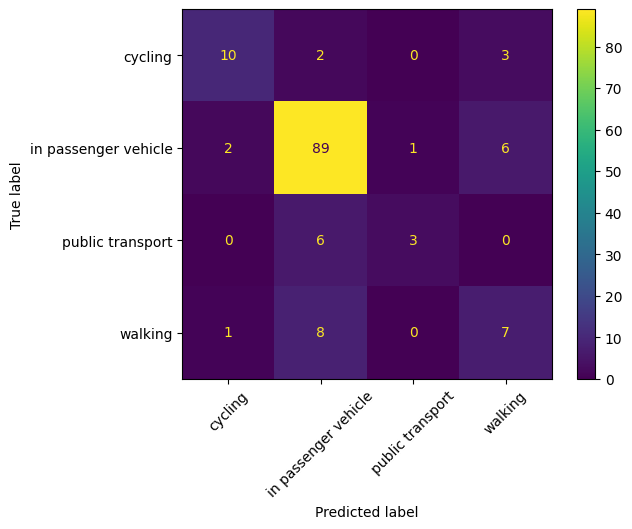

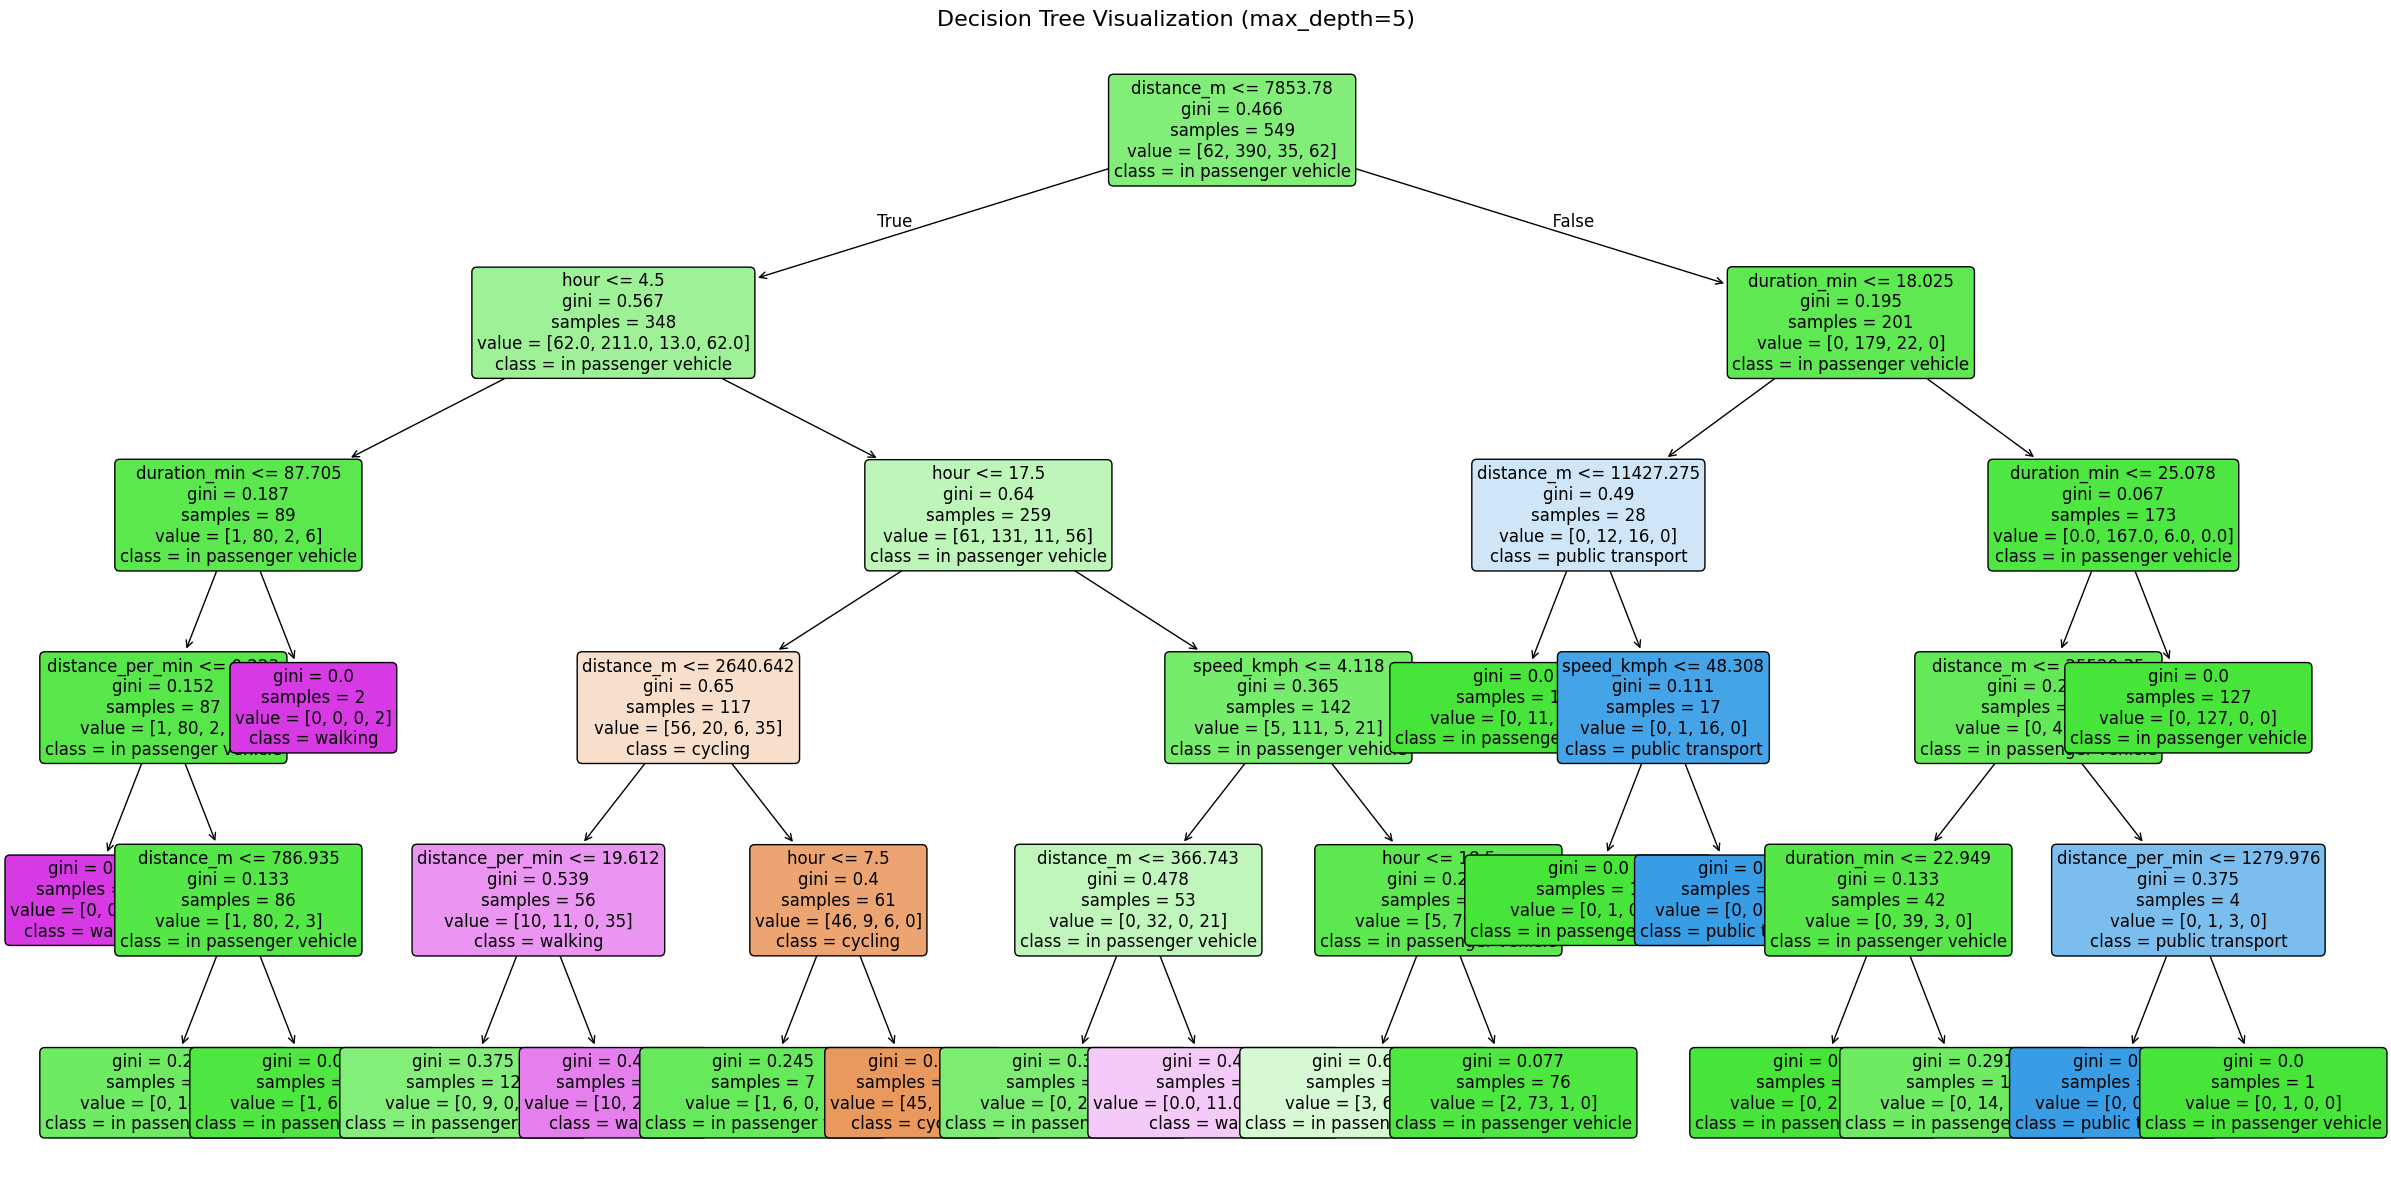

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
 

# labels
le_usa = LabelEncoder()
yk_encoded = le_usa.fit_transform(y_usa)

# Train-test split
Xk_train, Xk_test, yk_train, yk_test = train_test_split( X_usa, yk_encoded, stratify=yk_encoded, test_size=0.2, random_state=42)

# Train Decision Tree with timing
dt_model_usa = DecisionTreeClassifier(random_state=42, max_depth=5)
start_time = time.time()
dt_model_usa.fit(Xk_train, yk_train)
elapsed_time = round(time.time() - start_time, 2)

# Predict and evaluate
yk_pred = dt_model_usa.predict(Xk_test)
yk_test_labels = le_usa.inverse_transform(yk_test)
yk_pred_labels = le_usa.inverse_transform(yk_pred)

print("Decision Tree Classification Report (USA):")
print(classification_report(yk_test_labels, yk_pred_labels))
ConfusionMatrixDisplay.from_predictions(yk_test_labels, yk_pred_labels, xticks_rotation=45)

# Append results
accuracy = accuracy_score(yk_test_labels, yk_pred_labels)
macro_f1 = f1_score(yk_test_labels, yk_pred_labels, average='macro')

results.append({
    "Country": "USA",
    "Model": "Decision Tree",
    "Accuracy": round(accuracy, 2),
    "Precision": round(macro_precision, 2),
    "Recall": round(macro_recall, 2),
    "F1-Score": round(macro_f1, 2),
    "Time (s)": elapsed_time
})

# Decision tree visualization
plt.figure(figsize=(30, 15))
plot_tree(
    dt_model_usa,
    feature_names=X_usa.columns,
    class_names=le_usa.classes_,
    filled=True,
    rounded=True,
    proportion=False,
    fontsize=12
)
plt.title("Decision Tree Visualization (max_depth=5)", fontsize=16)
plt.show()


## Results

In [40]:
import pandas as pd

summary_df = pd.DataFrame(results)
summary_df.sort_values(by=["Country", "Model"])

,Country,Model,Accuracy,Precision,Recall,F1-Score,Time (s)
4,Egypt,Decision Tree,0.76,NaN,NaN,0.49,0.01
0,Egypt,Random Forest,0.91,0.55,0.52,0.53,0.19
1,Egypt,Random Forest GridSearch CV,0.90,0.52,0.54,0.53,8.84
2,Egypt,XGBoost,0.90,NaN,NaN,0.51,0.62
3,Egypt,XGBoost (Tuned),0.90,NaN,NaN,0.53,5.10
11,Kuwait,Decision Tree,0.95,NaN,NaN,0.37,0.01
5,Kuwait,Random Forest,0.96,NaN,NaN,0.41,0.18
7,Kuwait,Random Forest (Oversampled),0.95,NaN,NaN,0.42,0.23
6,Kuwait,Random Forest (Tuned),0.96,NaN,NaN,0.43,6.04
8,Kuwait,XGBoost (Oversampled),0.95,NaN,NaN,0.45,0.46


In [41]:
best_by_accuracy = summary_df.loc[summary_df.groupby("Country")["Accuracy"].idxmax()]
print("Best Model by Accuracy:")
display(best_by_accuracy)

best_by_f1 = summary_df.loc[summary_df.groupby("Country")["F1-Score"].idxmax()]
print("\nBest Model by F1-Score:")
display(best_by_f1)

Best Model by Accuracy:


,Country,Model,Accuracy,Precision,Recall,F1-Score,Time (s)
0,Egypt,Random Forest,0.91,0.55,0.52,0.53,0.19
10,Kuwait,XGBoost (Tuned),0.97,NaN,NaN,0.48,3.61
13,USA,Random Forest (Tuned),0.84,NaN,NaN,0.70,5.62



Best Model by F1-Score:


,Country,Model,Accuracy,Precision,Recall,F1-Score,Time (s)
0,Egypt,Random Forest,0.91,0.55,0.52,0.53,0.19
10,Kuwait,XGBoost (Tuned),0.97,NaN,NaN,0.48,3.61
14,USA,XGBoost,0.84,NaN,NaN,0.71,0.24


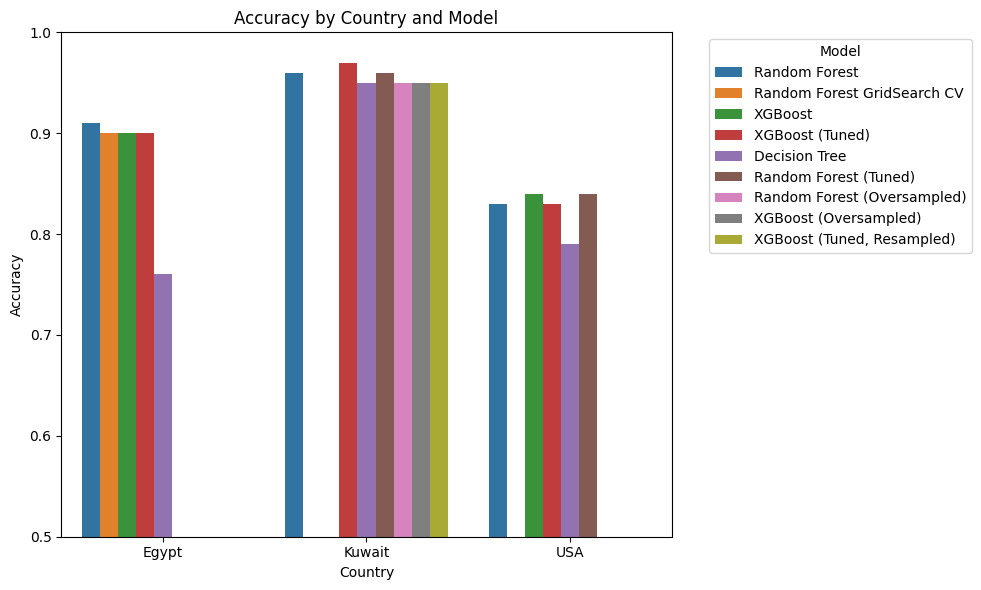

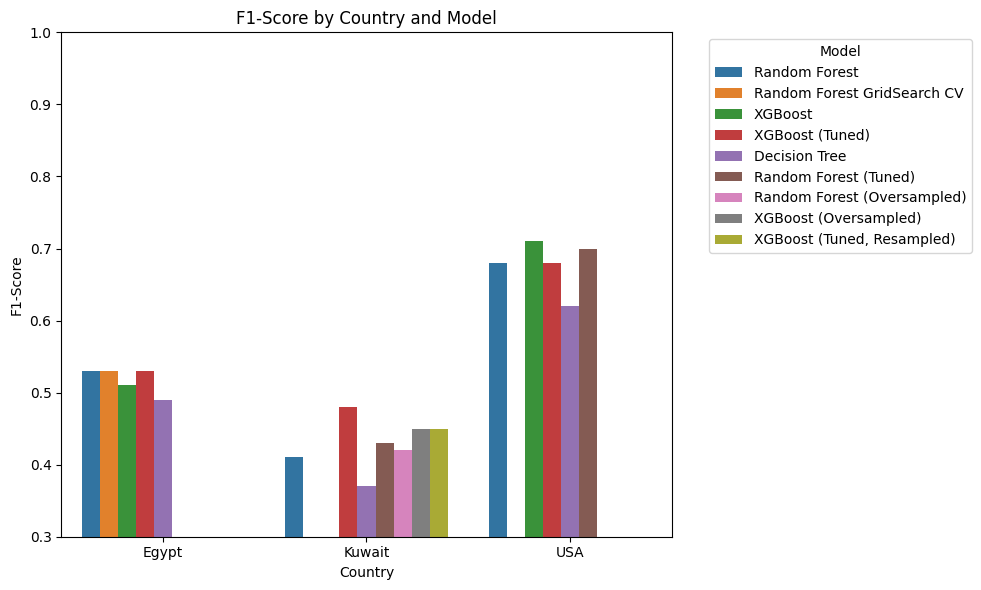

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="Country", y="Accuracy", hue="Model")
plt.title("Accuracy by Country and Model")
plt.ylim(0.5, 1.0)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# F1-Score Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="Country", y="F1-Score", hue="Model")
plt.title("F1-Score by Country and Model")
plt.ylim(0.3, 1.0)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


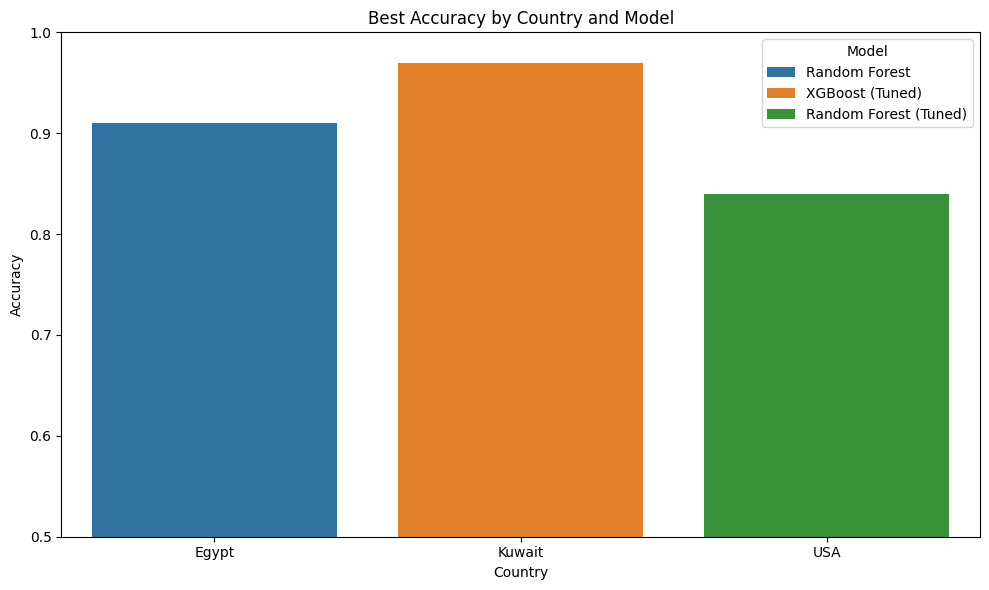

In [43]:
best_by_accuracy = summary_df.loc[summary_df.groupby("Country")["Accuracy"].idxmax()]
best_by_f1 = summary_df.loc[summary_df.groupby("Country")["F1-Score"].idxmax()]

plt.figure(figsize=(10, 6))
sns.barplot(data=best_by_accuracy, x="Country", y="Accuracy", hue="Model")
plt.title("Best Accuracy by Country and Model")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()

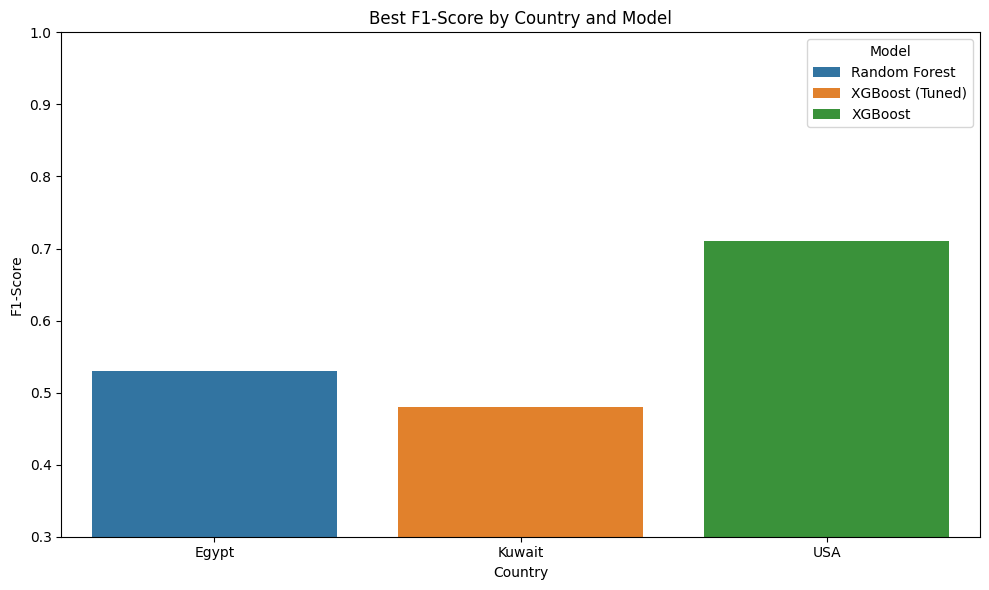

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(data=best_by_f1, x="Country", y="F1-Score", hue="Model")
plt.title("Best F1-Score by Country and Model")
plt.ylim(0.3, 1.0)
plt.tight_layout()
plt.show()


# Unsupervised

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [46]:
# Extracting the date from start_time
df["day"] = df["start_time"].dt.date

# group by day and country
daily_df = df.groupby(['day', 'country']).agg(
    total_duration_min=('duration_min', 'sum'),
    total_distance_m=('distance_m', 'sum'),
    num_transport_modes=('transport_type', 'nunique')
).reset_index()

# Calculate features
daily_df['avg_speed_kmph'] = (daily_df['total_distance_m'] / 1000) / (daily_df['total_duration_min'] / 60)
daily_df['avg_speed_kmph'] = daily_df['avg_speed_kmph'].fillna(0)


In [47]:
# Select relevant features
features = ["total_duration_min", "total_distance_m", "avg_speed_kmph", "num_transport_modes"]
scaler = StandardScaler()
X_cluster = scaler.fit_transform(daily_df[features])

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
daily_df["cluster"] = kmeans.fit_predict(X_cluster)


In [48]:
# clusters 
cluster_map = {
    0: "Home Day",
    1: "Commute Day",
    2: "Travel Day"
}

daily_df["cluster_label"] = daily_df["cluster"].map(cluster_map)


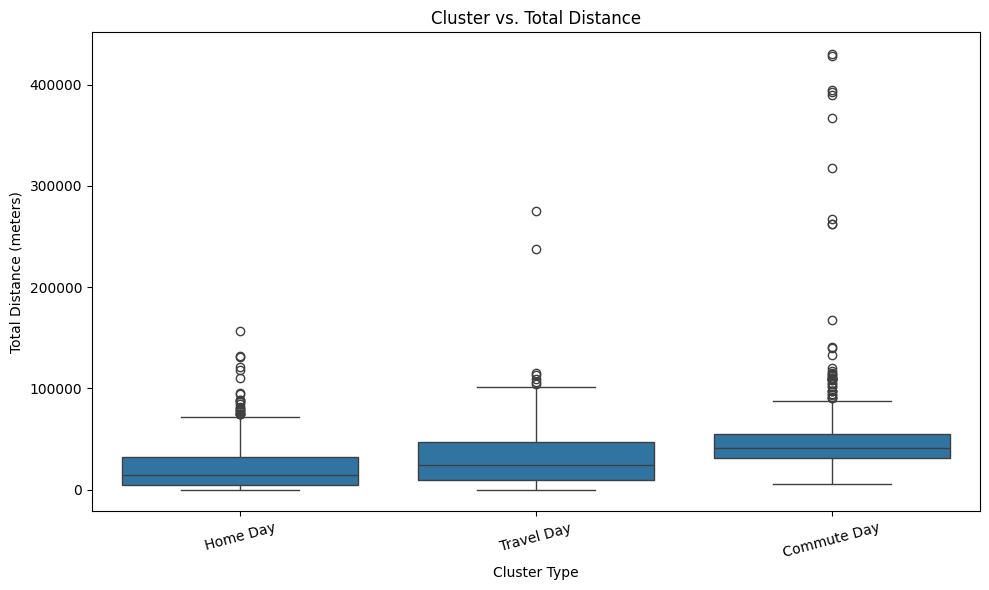

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x="cluster_label", y="total_distance_m", data=daily_df)
plt.title("Cluster vs. Total Distance")
plt.xlabel("Cluster Type")
plt.ylabel("Total Distance (meters)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


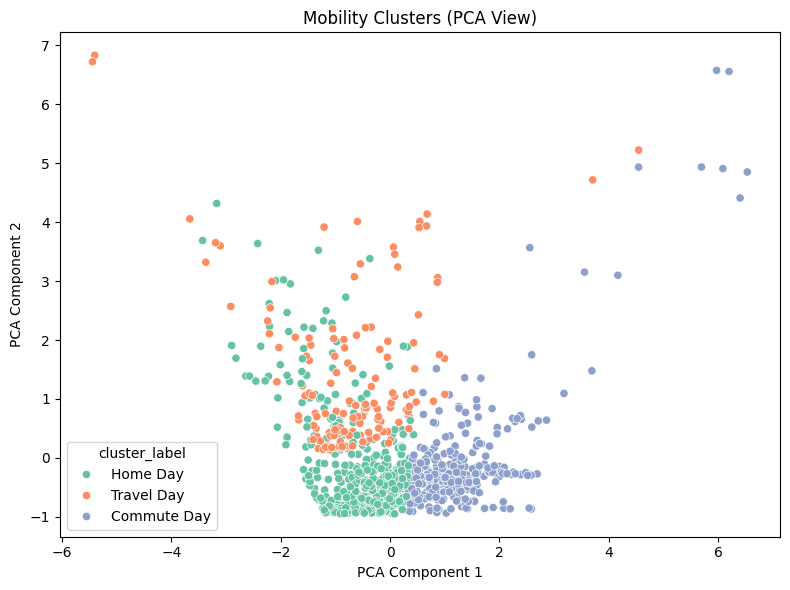

In [50]:
from sklearn.decomposition import PCA

# 2D PCA reduction
pca = PCA(n_components=2)
components = pca.fit_transform(X_cluster)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=daily_df["cluster_label"], palette="Set2")
plt.title("Mobility Clusters (PCA View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


Hourly Activity

In [51]:
import pytz

# Convert start_time to UTC datetime
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce', utc=True)

# Map country to timezone
timezone_map = {
    "Egypt": "Africa/Cairo",
    "Kuwait": "Asia/Kuwait",
    "USA": "America/Los_Angeles"
}

# Convert to local time
def convert_to_local(row):
    tz = pytz.timezone(timezone_map.get(row['country'], 'UTC'))
    return row['start_time'].astimezone(tz)

df['local_time'] = df.apply(convert_to_local, axis=1)

# Extract hour
df['hour'] = df['local_time'].apply(lambda x: x.hour)

# Extract date
df['day'] = df['start_time'].dt.date


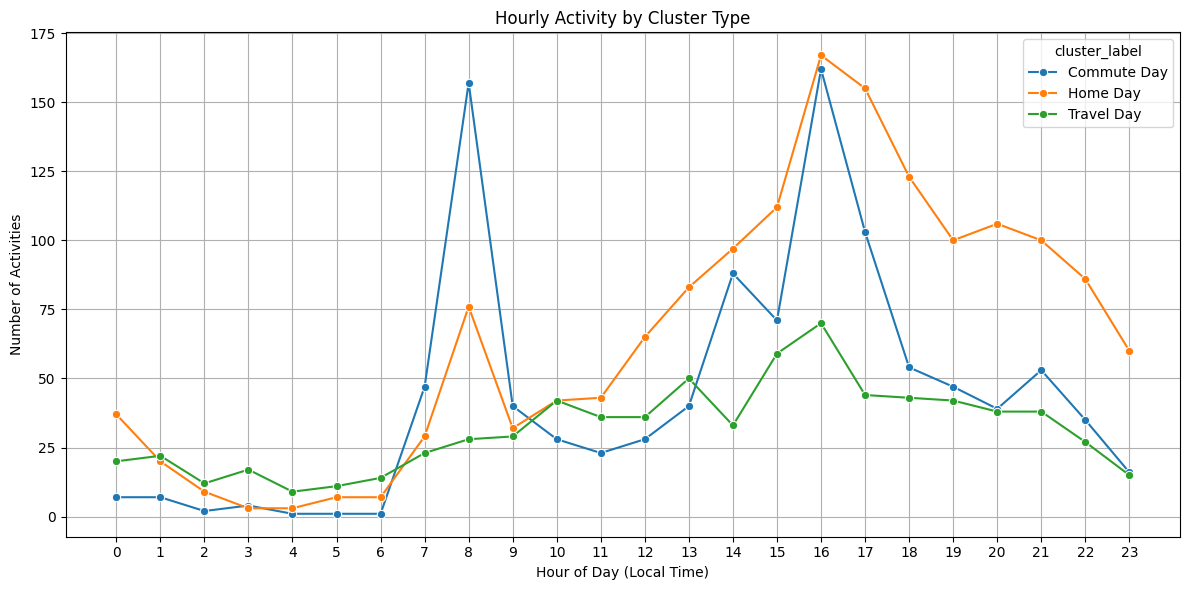

In [52]:
# Merge cluster labels into df
activity_with_labels = df.merge(
    daily_df[["day", "cluster_label"]],
    on="day", how="left"
)

# Use local time for hourly analysis
activity_with_labels["start_hour"] = activity_with_labels["local_time"].apply(lambda x: x.hour)

# Group by hour and cluster label
hourly_counts = activity_with_labels.groupby(["start_hour", "cluster_label"]).size().reset_index(name="count")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_counts, x="start_hour", y="count", hue="cluster_label", marker="o")
plt.title("Hourly Activity by Cluster Type")
plt.xlabel("Hour of Day (Local Time)")
plt.ylabel("Number of Activities")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()
